## Пример: классификация CIFAR10

In [1]:
from collections import defaultdict
from pathlib import Path
from typing import Callable

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
torch.manual_seed(42)

datadir = Path("../assets/datasets")
datadir.mkdir(exist_ok=True, parents=True)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = datasets.CIFAR10(
    root=datadir, train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root=datadir, train=False, download=True, transform=transform
)

Посмотрим на примеры изображений:

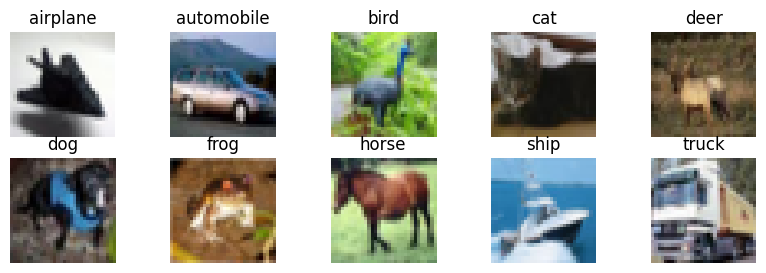

In [3]:
nrows = 2
ncols = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3))
for k, label in enumerate(train_dataset.classes):
    example = next(img for img, target in train_dataset if target == k)
    # unnormalize images
    example = 0.5 * example + 0.5
    row = k // ncols
    column = k % ncols
    ax = axes[row][column]
    ax.imshow(transforms.ToPILImage()(example), cmap="gray")
    ax.set_title(label)
    ax.set_axis_off()

plt.show()

In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Определим простую архитектуру: 2 блока из свёртки и maxpooling, три линейных слоя, ReLU в качестве нелинейности

In [5]:
class CNNet(nn.Module):
    def __init__(self, num_classes: int = 10, input_channels: int = 3):
        super().__init__()
        self._num_classes = num_classes
        # conv block
        self.conv1 = nn.Conv2d(input_channels, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)

        # linear block
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    @property
    def num_classes(self) -> int:
        return self._num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Наши функции для запуска обучения:

In [6]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
) -> tuple[Tensor, Tensor]:
    model.to(device=device)
    # прогоняем батч через модель
    x, y = batch
    logits = model(x.to(device=device))
    # оцениваем значение ошибки
    loss = F.cross_entropy(logits, y.to(device=device))
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, logits


def train_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    max_batches: int = 100,
    device: str = "cpu",
) -> dict[str, float]:
    model.train()
    loss_total = 0
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(dataloader):
        x, y = batch
        loss, logits = training_step(batch, model, optimizer, device)

        # save stats
        n_total += y.size(0)
        n_correct += (y.to(device=device) == logits.argmax(dim=1)).sum()
        loss_total += y.size(0) * loss.item()
        if i == max_batches:
            break

    return {
        "loss": loss_total / n_total,
        "accuracy": n_correct / n_total,
    }


@torch.no_grad()
def test_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    max_batches: int = 100,
    device: str = "cpu",
) -> Tensor:
    model.eval()
    model.to(device=device)
    loss_total = 0
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(dataloader):
        x, y = batch
        logits = model(x.to(device=device))
        # оцениваем значение ошибки
        loss = F.cross_entropy(logits, y.to(device=device))
        # save stats
        n_total += y.size(0)
        n_correct += (y.to(device=device) == logits.argmax(dim=1)).sum()
        loss_total += y.size(0) * loss.item()
        if i == max_batches:
            break

    return {
        "loss": loss_total / n_total,
        "accuracy": n_correct / n_total,
    }


def run_experiment(
    model_gen: Callable[[], nn.Module],
    optim_gen: Callable[[nn.Module], torch.optim.Optimizer],
    seed: int,
    n_epochs: int = 10,
    max_batches: int | None = None,
    verbose: bool = False,
    device: str = "cpu",
) -> dict[str, list[float]]:
    """Функция для запуска экспериментов.

    Args:
        model_gen (Callable[[], nn.Module]): Функция для создания модели
        optim_gen (Callable[[nn.Module], torch.optim.Optimizer]): Функция для создания оптимизатора для модели
        seed (int): random seed
        n_epochs (int, optional): Число эпох обучения. Defaults to 10.
        max_batches (int | None, optional): Если указано, только `max_batches` минибатчей
            будет использоваться при обучении и тестировании. Defaults to None.
        verbose (bool, optional): Выводить ли информацию для отладки. Defaults to False.

    Returns:
        tuple[list[float], list[float]]: Значения ошибки на обучающей и тестовой выборках по всем эпохам
    """
    torch.manual_seed(seed)
    # создадим модель и выведем значение ошибки после инициализации
    model = model_gen()
    optim = optim_gen(model)
    metrics: dict[str, list[float]] = defaultdict(list)
    for i in range(n_epochs):
        train_dict = train_epoch(
            train_loader, model, optim, max_batches=max_batches, device=device
        )
        test_dict = test_epoch(
            test_loader, model, max_batches=max_batches, device=device
        )
        train_loss, train_accuracy = train_dict["loss"], train_dict["accuracy"]
        test_loss, test_accuracy = test_dict["loss"], test_dict["accuracy"]
        if verbose:
            print(
                f"Epoch {i} train: loss = {train_loss:.4f}, accuracy = {train_accuracy:.4f}"
            )
            print(
                f"Epoch {i} test: loss = {test_loss:.4f}, accuracy = {test_accuracy:.4f}"
            )

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
        metrics["test_losses"].append(test_loss)
        metrics["test_accuracies"].append(test_accuracy)

    return metrics

Запустим эксперимент

In [7]:
metrics_dict = run_experiment(
    model_gen=lambda: CNNet(),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001, weight_decay=0.00),
    seed=42,
    n_epochs=10,
    max_batches=None,
    verbose=True,
    device="cpu",
)

Epoch 0 train: loss = 1.4968, accuracy = 0.4589
Epoch 0 test: loss = 1.2481, accuracy = 0.5516
Epoch 1 train: loss = 1.1621, accuracy = 0.5864
Epoch 1 test: loss = 1.0747, accuracy = 0.6141
Epoch 2 train: loss = 1.0144, accuracy = 0.6419
Epoch 2 test: loss = 1.0119, accuracy = 0.6407
Epoch 3 train: loss = 0.9121, accuracy = 0.6795
Epoch 3 test: loss = 0.9657, accuracy = 0.6631
Epoch 4 train: loss = 0.8295, accuracy = 0.7084
Epoch 4 test: loss = 0.9531, accuracy = 0.6644
Epoch 5 train: loss = 0.7662, accuracy = 0.7339
Epoch 5 test: loss = 0.9102, accuracy = 0.6834
Epoch 6 train: loss = 0.7149, accuracy = 0.7503
Epoch 6 test: loss = 0.9300, accuracy = 0.6838
Epoch 7 train: loss = 0.6647, accuracy = 0.7674
Epoch 7 test: loss = 0.9052, accuracy = 0.6907
Epoch 8 train: loss = 0.6229, accuracy = 0.7797
Epoch 8 test: loss = 0.9301, accuracy = 0.6913
Epoch 9 train: loss = 0.5819, accuracy = 0.7958
Epoch 9 test: loss = 0.9665, accuracy = 0.6806
